### save it as html before submitting

In [129]:

import sqlite3
import os
import pandas as pd
import operator

# change to the directory where the files are stored
os.chdir("/Users/christopherpang/Desktop/Main/SIM uni year 2/Programming for data science/Coursework_data/dataverse_files")

try:
    os.remove('airline2.db')
except OSError:
    pass



# ======= create database =======
conn = sqlite3.connect('airline2.db')
#v1
#data1999= pd.read_csv("1999.csv")
#data2000= pd.read_csv("2000.csv")

#ontime_df = pd.concat([data1999,data2000], ignore_index=True, sort=False)


#v2
data_frames = []

# Loop through the years from 1991 to 2000
for year in range(1991, 2001):
    # Construct the file path for the CSV file
    file_path = f"{year}.csv"
    
    # Read the CSV file into a DataFrame
    data = pd.read_csv(file_path)
    
    # Append the DataFrame to the list
    data_frames.append(data)

    
    
# adding all DataFrames in the list into a single DataFrame
ontime_df = pd.concat(data_frames, ignore_index=True, sort=False)
airports_df = pd.read_csv("airports.csv")
carriers_df = pd.read_csv("carriers.csv")
planes_df = pd.read_csv("plane-data.csv")
#print(ontime_df.head)


# ======= statistics summary =======
summaryAirports = airports_df.describe(include='all')
#print(summaryAirports)

summaryCarriers = carriers_df.describe(include='all')
#print(summaryCarriers)

summaryPlanes = planes_df.describe(include='all')
#print(summaryPlanes)

summaryOntime = ontime_df.describe(include='all')
#print(summaryOntime)

c = conn.cursor()
c.execute('''
CREATE TABLE ontime (
  Year int,
  Month int,
  DayofMonth int,
  DayOfWeek int,
  DepTime  int,
  CRSDepTime int,
  ArrTime int,
  CRSArrTime int,
  UniqueCarrier varchar(5),
  FlightNum int,
  TailNum varchar(8),
  ActualElapsedTime int,
  CRSElapsedTime int,
  AirTime int,
  ArrDelay int,
  DepDelay int,
  Origin varchar(3),
  Dest varchar(3),
  Distance int,
  TaxiIn int,
  TaxiOut int,
  Cancelled int,
  CancellationCode varchar(1),
  Diverted varchar(1),
  CarrierDelay int,
  WeatherDelay int,
  NASDelay int,
  SecurityDelay int,
  LateAircraftDelay int
)
''')
conn.commit()




for year in range(1991, 2000):
    ontime = pd.read_csv(str(year)+".csv")
    ontime.to_sql('ontime', con = conn, if_exists = 'append', index = False)

conn.commit()



# ======= creating planData Table =======
conn = sqlite3.connect('airline2.db')
c = conn.cursor()
c.execute("DROP TABLE IF EXISTS planData")

c.execute('''CREATE TABLE planeData (
  Tailnum varchar(6),
  Type varchar(25),
  Manufacturer varchar(25),
  Issue_date varchar(10),
  Model varchar(10),
  Status varchar(5),
  Aircraft_type varchar(25),
  Engine_type varchar(25),
  Year int 
      
)
''')


conn.commit()

# ======= getting the issue date of the planes that have less delays =======
planes_df.to_sql('planeData', con = conn, if_exists = 'append', index = False)

conn.commit()

planeNum=c.execute(''' SELECT Issue_date FROM planeData JOIN ontime ON planeData.Tailnum= ontime.Tailnum WHERE ArrDelay < '5' AND DepDelay < '5'
''').fetchall()

column_name1=["IssueDate"]
issueDatePd= pd.DataFrame(planeNum, columns= column_name1)


# ======= getting the deptime for flights that delay less than 5 mins  =======
timeOfDay= c.execute(''' SELECT DepTime AS DepTime FROM ontime 
                         WHERE ArrDelay < '5' AND DepDelay < '5' 
    
''').fetchall()

column_name=["DepTime"]
timeOfDayPd=pd.DataFrame(timeOfDay, columns= column_name)

# ======= Answering Q1 best time of the week to fly   =======
timeOfDayPd['DepTime'] = timeOfDayPd['DepTime'].astype(str).str.zfill(4)
print(timeOfDayPd)
type(timeOfDayPd)

earlyMornCount=0  
midMornCount=0
lateMornCount=0
earlyAftCount=0
midAftCount=0
lateAftCount= 0
earlyEveCount=0
midEveCount=0
lateEveCount=0 
earlyOverCount=0
midOverCount=0
lateOverCount=0

for index, i in timeOfDayPd.iterrows():  
    #print(int(i['DepTime']))
    
    if 600<= int(i['DepTime']) <=800:
        
        earlyMornCount+=1
        #print(type(i['DepTime']))
            #print({'col1':i['DepTime']})
            
    elif 800<= int(i['DepTime']) <= 1000:   
        midMornCount+=1
        
    elif 1000<= int(i['DepTime']) <= 1200:   
        lateMornCount+=1
        
    elif 1200 <= int(i['DepTime']) <= 1400:
        earlyAftCount+=1
       #print(timeOfDayPdMorn)    
    
    elif 1400 <= int(i['DepTime']) <= 1600:
        midAftCount+=1
        
    elif  1600 <= int(i['DepTime']) <= 1800:
          lateAftCount+=1
            
    elif  1800 <= int(i['DepTime']) <= 2000:
         earlyEveCount+=1
        
    elif  2000 <= int(i['DepTime']) <= 2200:   
        midEveCount+=1
        
    elif  2200 <= int(i['DepTime']) <= 2359:     
        lateEveCount+=1
        
    elif  1 <= int(i['DepTime']) <= 200: 
        earlyOverCount+=1
        
    elif  200 <= int(i['DepTime']) <= 400: 
        midOverCount+=1
        
    elif  400 <= int(i['DepTime']) <= 600: 
        lateOverCount+=1
        
print( earlyMornCount) 
print( midMornCount)
print(lateMornCount)
print(earlyAftCount)
print(midAftCount)
print(lateAftCount)
print(earlyEveCount)
print(midEveCount)
print(lateEveCount)
print( earlyOverCount)
print(midOverCount)

print("Best time of the day to fly is early morning from 0600 to 0800")

#timeOfDayPdMorn2=pd.DataFrame(timeOfDayPdMorn, columns= column_name)
#print(len(timeOfDayPdMorn2))    
#print(timeOfDayPdMorn2)

    
        
       
   
    







         DepTime
0           1709
1           1704
2           1705
3           1703
4           1704
...          ...
25861036    1912
25861037    1910
25861038    1909
25861039    1907
25861040    1907

[25861041 rows x 1 columns]
4132559
3792118
3231924
3420438
2932059
2972456
2666592
1861940
461907
149456
15498
Best time of the day to fly is early morning from 0600 to 0800


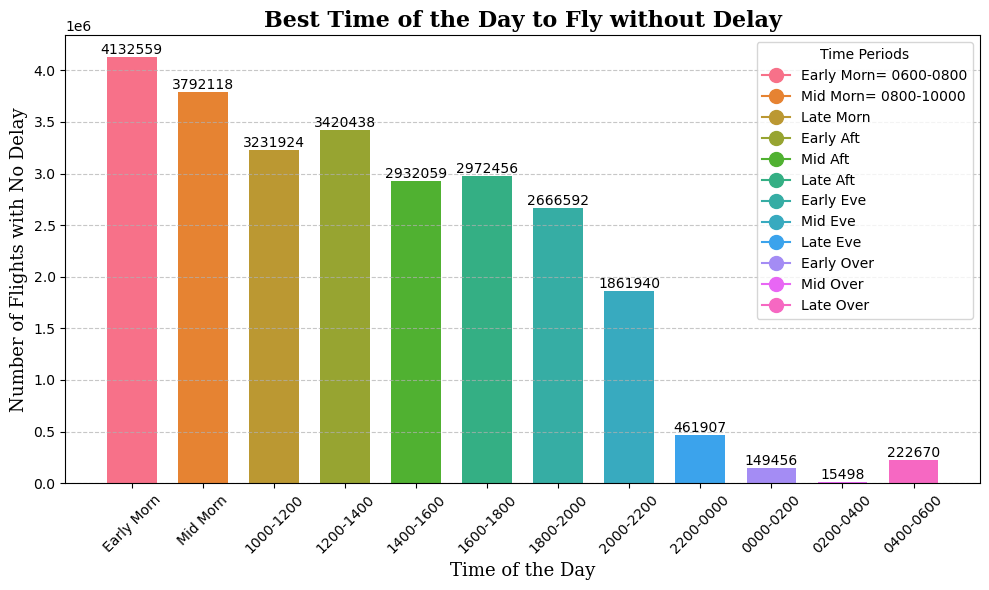

In [198]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# For y Aaxis
flight_counts = [earlyMornCount, midMornCount, lateMornCount, earlyAftCount, midAftCount, lateAftCount, earlyEveCount, 
                 midEveCount, lateEveCount, earlyOverCount, midOverCount, lateOverCount]

# Time intervals for x-axis
time_intervals = ['Early Morn', 'Mid Morn', '1000-1200', '1200-1400', '1400-1600', '1600-1800', '1800-2000', 
                  '2000-2200', '2200-0000', '0000-0200', '0200-0400', '0400-0600']

# Set color 
colors = sns.color_palette("husl", len(time_intervals))

# Plot graph
plt.figure(figsize=(10, 6))
bars = plt.bar(time_intervals, flight_counts, color=colors, width=0.7)

# Add data labels on top of each bar
for i, count in enumerate(flight_counts):
    plt.text(i, count + 100, str(count), ha='center', va='bottom')

# Rotate x axis
plt.xticks(rotation=45)

# Labels and title
plt.xlabel('Time of the Day', fontdict={'fontsize': 13, 'family': 'serif'})
plt.ylabel('Number of Flights with No Delay',fontdict={'fontsize': 13, 'family': 'serif'})
plt.title('Best Time of the Day to Fly without Delay', fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'serif'})

# Add legend with custom labels
legend_labels = ['Early Morn= 0600-0800', 'Mid Morn= 0800-10000', 'Late Morn', 'Early Aft', 'Mid Aft', 'Late Aft',
                 'Early Eve', 'Mid Eve', 'Late Eve', 'Early Over', 'Mid Over', 'Late Over']
legend_elements = [Line2D([0], [0], color=colors[i], marker='o', markerfacecolor=colors[i], markersize=10, label=label) 
                   for i, label in enumerate(legend_labels)]

plt.legend(handles=legend_elements, loc='upper right', title='Time Periods')

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()








### Answering Q2a) best day of the week to fly to minimize delays

In [27]:
# ======= Answering Q1b best day of the week to fly to minimize delays   =======


# ======= getting the day of week for flights that delay less than 5 mins  =======
dayOfWeek= c.execute(''' SELECT DayOfWeek  AS DayOfWeek FROM ontime 
                         WHERE ArrDelay < '5' AND DepDelay < '5' 
    
''').fetchall()

column_name=["DayOfWeek"]
dayOfWeekPd=pd.DataFrame(dayOfWeek, columns= column_name)
print(dayOfWeekPd)


monCount=0  
tuesCount=0
wedCount=0
thursCount=0
friCount=0
satCount=0
sunCount=0
for index, i in dayOfWeekPd.iterrows():  

    if int(i['DayOfWeek']) ==1:
            monCount+=1
    
    elif int(i['DayOfWeek']) ==2:
         tuesCount+=1
    
    elif int(i['DayOfWeek']) ==3:
         wedCount+=1
            
    elif int(i['DayOfWeek']) ==4:
         thursCount+=1
            
    elif int(i['DayOfWeek']) ==5:
         friCount+=1
            
    elif int(i['DayOfWeek']) ==6:
         satCount+=1
            
    else:
         sunCount+=1
    
print(monCount)
print(tuesCount)
print(wedCount)
print(thursCount)
print(friCount)
print(satCount)
print(sunCount)



          DayOfWeek
0                 2
1                 3
2                 4
3                 6
4                 2
...             ...
25861036          3
25861037          4
25861038          5
25861039          6
25861040          7

[25861041 rows x 1 columns]
3934129
3979088
3783559
3532264
3420864
3601183
3609954


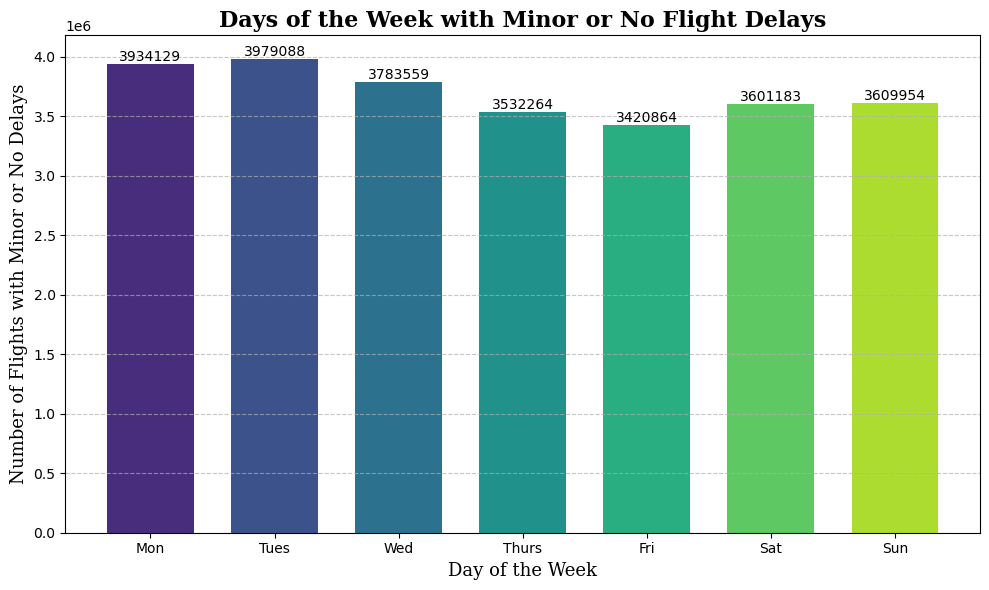

Best day of the week to fly is on a Tuesday


In [182]:
# ======= plotting graph for Q1b  =======

import pandas as pd
from matplotlib import pyplot as plt

  
#x-coordinates of left sides of bars  
left = [0, 1, 2, 3, 4, 5, 6] 
  
# heights of bars 
height = [monCount, tuesCount, wedCount , thursCount, friCount, satCount, sunCount ] 
  

# labels for bars 
tick_label = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'] 

# Set color palette
colors = sns.color_palette("viridis", len(tick_label))


# plotting a bar chart 
plt.figure(figsize=(10, 6))
plt.bar(left, height, tick_label = tick_label, 
        width = 0.7, color = colors) 

# Add data labels on top of each bar
for i, count in enumerate(height):
    plt.text(i, count + 100, str(count), ha='center', va='bottom')

# Labels and title
plt.xlabel('Day of the Week', fontdict={'fontsize': 13, 'family': 'serif'})
plt.ylabel('Number of Flights with Minor or No Delays',fontdict={'fontsize': 13, 'family': 'serif'})
plt.title('Days of the Week with Minor or No Flight Delays',fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'serif'})
  
# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show() 

print("Best day of the week to fly is on a Tuesday")






### Answering question 1C, best time of the year to fly to miinimize delays

In [166]:
# ======= Answering Q1c best time of the year to fly to mimimize delays  =======


# ======= getting the year for flights that delay less than 5 mins  =======


timeOfYear= c.execute(''' SELECT Month AS Month FROM ontime 
                         WHERE ArrDelay < '5' AND DepDelay < '5' 
    
''').fetchall()


column_name=["Month"]
timeOfYearPd=pd.DataFrame(timeOfYear, columns= column_name)
print(timeOfYearPd)





janCount=0  
febCount=0
marchCount=0
aprilCount=0
mayCount=0
juneCount= 0
julyCount=0
augCount=0
septCount=0 
octCount=0
novCount=0
decCount=0

for index, i in timeOfYearPd.iterrows():  
    #print(int(i['DepTime']))
    
    if int(i['Month']) == 1:
        
        janCount+=1      
            
    elif int(i['Month']) == 2:   
        febCount+=1
        
    elif int(i['Month']) == 3:   
        marchCount+=1
        
    elif int(i['Month']) == 4:
        aprilCount+=1
       #print(timeOfDayPdMorn)    
    
    elif int(i['Month']) == 5:
        mayCount+=1
        
    elif  int(i['Month']) == 6:
        juneCount+=1
            
    elif  int(i['Month']) == 7:
        julyCount+=1
            
    elif  int(i['Month']) == 8:
        augCount+=1
            
    elif  int(i['Month']) == 9:
        septCount+=1
            
            
    elif  int(i['Month']) == 10:
        octCount+=1
            
    elif  int(i['Month']) == 11:
        novCount+=1
            
    elif  int(i['Month']) == 12:
        decCount+=1
            
            

            


          Month
0             1
1             1
2             1
3             1
4             1
...         ...
25861036     12
25861037     12
25861038     12
25861039     12
25861040     12

[25861041 rows x 1 columns]


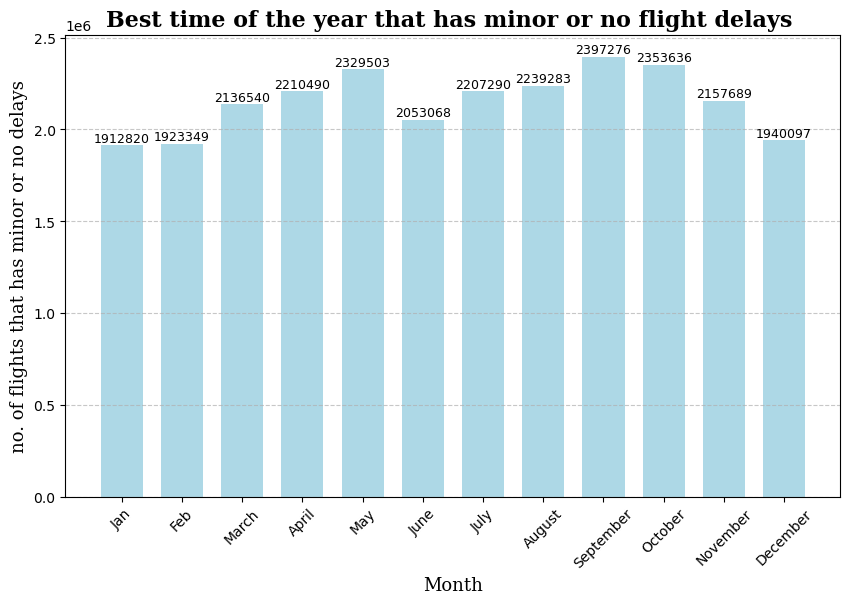

Best time of the year to fly is September 


In [197]:
#Plotting graph for Q1C When is the best time of the year to fly to mimimize delays

import pandas as pd
from matplotlib import pyplot as plt

  
# x-coordinates of left sides of bars  
left = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] 
  
# heights of bars 
height_months = [janCount, febCount, marchCount , aprilCount, mayCount, juneCount, julyCount,
         augCount, septCount, octCount, novCount, decCount] 
  
    

# labels for bars 
months_label = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October'
             , 'November', 'December'] 


# plotting a bar chart 
plt.figure(figsize=(10, 6))
plt.bar(left, height_months, tick_label = months_label, 
        width = 0.7, color = ['lightblue']) 

# Add data labels on top of each bar
for i, count in enumerate(height_months):
    plt.text(i, count + 100, str(count), ha='center', va='bottom', fontsize=9)
    
# Labels and title
plt.xlabel('Month', fontdict={'fontsize': 13, 'family': 'serif'}) 
plt.ylabel('no. of flights that has minor or no delays', fontdict={'fontsize': 13, 'family': 'serif'}) 
plt.title('Best time of the year that has minor or no flight delays ', fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'serif'}) 


# Rotating the x-axis labels
plt.xticks(rotation=45, fontsize= 10)

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)



plt.show() 

print("Best time of the year to fly is September ")


### Answering question do older planes suffer more delays 

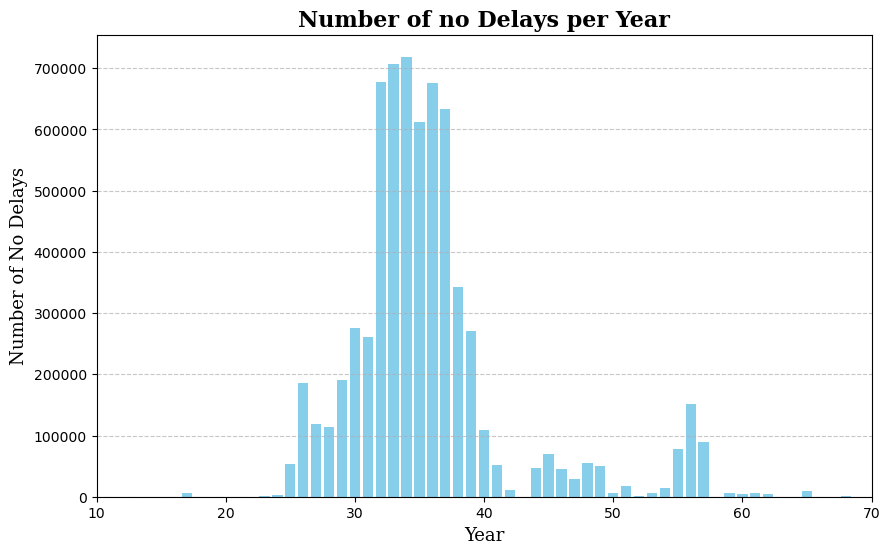

In [213]:
from matplotlib import pyplot as plt
# Fetch data from the database
dateOfPlane = c.execute('''
    SELECT CAST(planeData.year AS INTEGER) AS year
    FROM planeData
    JOIN ontime ON planeData.TailNum = ontime.TailNum
    WHERE CAST(ontime.ArrDelay AS INTEGER) < 15 AND CAST(ontime.DepDelay AS INTEGER) < 15
    AND planeData.year IS NOT NULL
''').fetchall()

# Create a DataFrame
column_name = ["Year"]
datesOfPlaneDp = pd.DataFrame(dateOfPlane, columns=column_name)

# Convert 'Year' column to integers and subtract from 2024
datesOfPlaneDp['Year'] = datesOfPlaneDp['Year'].apply(lambda x: 2024 - int(x) if isinstance(x, (int, str)) and str(x).isdigit() else x)

# Group by year and count the occurrences
delay_counts = datesOfPlaneDp['Year'].value_counts().sort_index()

# Plot the graph
plt.figure(figsize=(10, 6))
bars=plt.bar(delay_counts.index, delay_counts.values, color='skyblue')


    
# Labels and title
plt.title('Number of no Delays per Year', fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'serif'})
plt.xlabel('Year',  fontdict={'fontsize': 13, 'family': 'serif'})
plt.ylabel('Number of No Delays',  fontdict={'fontsize': 13, 'family': 'serif'})

#Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)



plt.xlim(10, 70) 


plt.show()



### Answering Q2c) Logistic regression


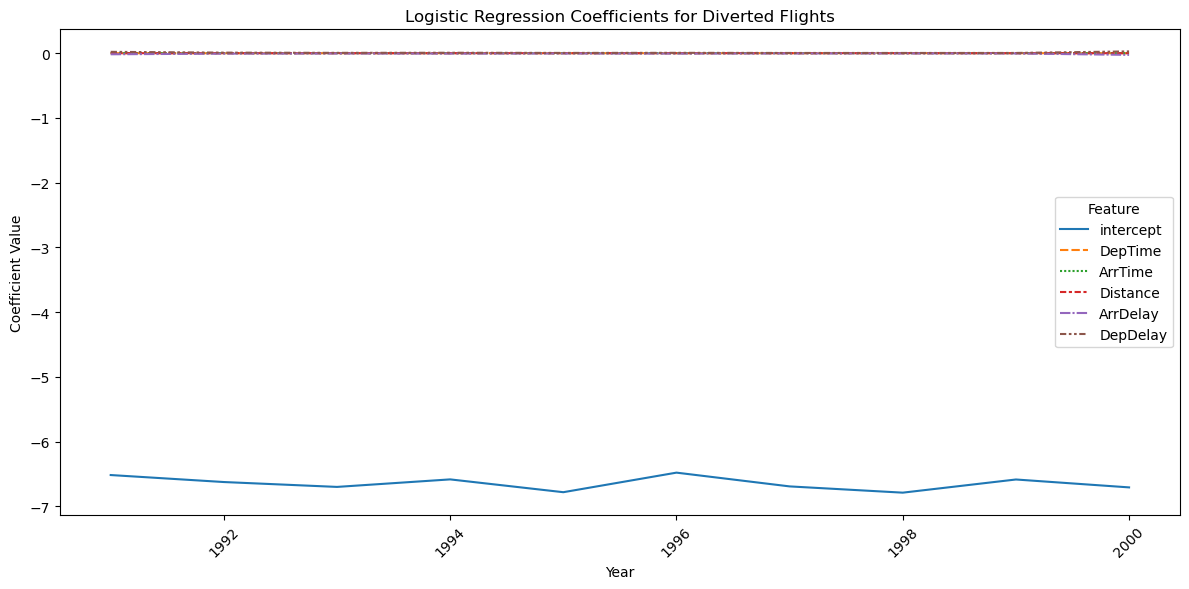

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

airportData= pd.read_csv('/Users/christopherpang/Desktop/Main/SIM uni year 2/Programming for data science/Coursework_data/dataverse_files/plane-data.csv')
merged_df =pd.merge()

features = [ 'DepTime', 'ArrTime', 'Distance', 'ArrDelay', 'DepDelay']

target = 'Diverted'

# Initialize an empty DataFrame to store coefficients
coefficients_df = pd.DataFrame()

for year in range(1991, 2001):

    year_data = ontime_df[ontime_df['Year'] == year].copy()

   
 # Impute missing values in features
    imputer = SimpleImputer(strategy='mean')
    year_data.loc[:, features] = imputer.fit_transform(year_data.loc[:, features])


    # Fit logistic regression model
    X = year_data[features]
    y = year_data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, y_train)
    
    #get coefficients and intercept 
    coefficients = logistic_model.coef_.flatten()
    coefficients = [logistic_model.intercept_[0]] + list(coefficients)
    
    #create a DataFrame to store co
    coefficients_series = pd.Series(coefficients, name=year, index=['intercept'] + features)
    coefficients_df = pd.concat([coefficients_df, coefficients_series],axis=1)

    
    # Visualize the coefficients across years
plt.figure(figsize=(12, 6))
sns.lineplot(data=coefficients_df.T)
plt.title('Logistic Regression Coefficients for Diverted Flights')
plt.xlabel('Year')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.legend(title='Feature')
plt.tight_layout()
plt.show()


  
